In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy import optimize
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
from numpy.random import default_rng

In [2]:
path = "C:\Physics_Master\Master_Arbeit\HAL_demo\hal_simulation\FakeAthenSimulation\\full_to\\"
# path = "C:\Physics_Master\Master_Arbeit\HAL_demo\hal_simulation\FakeAthenSimulation\\control_1amp_0_1_riserate\\"
files = np.array(["full_U{0}_M{1}.csv".format(i,j) for i in [0,1] for j in [0,1,2]])
U0M0 = pd.read_csv(path+files[0])

Analytical Results in Implementation

In [3]:
# mu == omega, eta = delta, nu = phi
def rabi_cor_x(t, mu, eta, nu):
    alpha = np.arctan(np.cos(nu)/(np.sin(nu)*np.sin(eta)))
    return np.sin(nu)*np.sin(eta)*np.cos(eta)-np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.sin(nu)**2)*np.cos(2*mu*t-alpha)

def rabi_cor_y(t, mu, eta, nu):
    gamma = np.arctan(np.sin(nu)/(np.cos(nu)*np.sin(eta)))
    return np.cos(nu)*np.sin(eta)*np.cos(eta)+np.cos(eta)*np.sqrt()

Rabi Model from Paper

In [4]:
def rabi_x(t, mu, eta, nu):
    alpha = np.arctan(np.tan(nu)/np.sin(eta))
    return np.sin(eta)*np.cos(eta)*np.cos(nu)+np.cos(eta)*np.sqrt(1-np.cos(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+alpha)

def rabi_y(t, mu, eta, nu):
    gamma = np.pi-np.arctan(1/(np.tan(nu)*np.sin(eta)))
    return np.sin(eta)*np.cos(eta)*np.sin(nu)+np.cos(eta)*np.sqrt(1-np.sin(eta)**2*np.cos(nu)**2)*np.cos(2*mu*t+gamma)

def rabi_z(t, mu, eta, nu):
    return 1-2*np.cos(eta)**2*np.sin(mu*t)**2

Corrected version of the Papaer

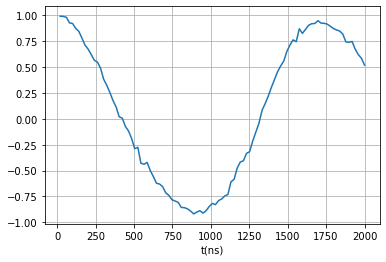

In [22]:
U0M1 = pd.read_csv(path+files[5])
# samp = [19,22,28,34,55,57,66,79,90]
dt = 2.2222222222222221e-10
t = U0M1["t"][1:][:]*dt
p = U0M1["count"][1:].to_numpy()
# p = np.sin(1.6e6*t*2*np.pi+0.8*np.pi)[:]
plt.plot(t*1e9,p)
plt.xlabel("t(ns)")
plt.grid()

[0.58689459]


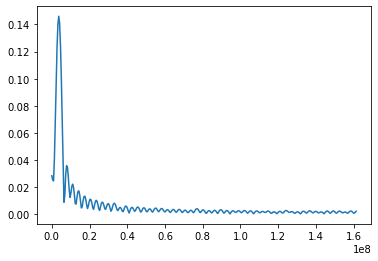

In [23]:
from scipy.fft import fft, fftfreq

# def zero_padding(N_zero, t, p):
#     dt = np.mean(np.diff(t))
#     t_pad = N_zero*dt
#     t =

dt = 2.2222222222222221e-10
t_max = 20e-7
N_interp = len(t)+5
t_intp = np.linspace(0, t_max, N_interp)[1:]#  !Important, endpoint= False
p_intp = np.interp(t_intp, t, p)


n_pad = len(t)+500
del_t = np.diff(t_intp)[0]
t_intp_pad = np.linspace(0, t_max+n_pad*del_t, N_interp+n_pad)[1:]
p_intp_pad = np.pad(p_intp, (0, n_pad))
# print(t_intp_pad)
# print(t_intp)
# plt.plot(t_intp_pad, p_intp_pad)
# plt.plot(t_intp,p_intp)
# plt.plot(t,p)
# print(t_intp)


yf = fft(p_intp_pad)
y_fft = 2.0/len(t_intp_pad) * np.abs(yf[:len(t_intp_pad)//2])
omgf = fftfreq(len(t_intp_pad), del_t)[:len(t_intp_pad)//2]*np.pi*2
f0 = omgf[np.where(y_fft==np.max(y_fft))]
plt.plot(omgf, y_fft)
# print(np.diff(omgf)/(2*np.pi)/1e6)
print(f0/(2*np.pi)/1e6)

In [27]:
from scipy.optimize import minimize, curve_fit

def loss_optimizer(lam, t, p, func):
    return np.sum((p-func(t, *lam))**2)/len(t)

def rabi_func(t, omg, A, B, C):
    return A*np.sin(omg*t)+B*np.cos(omg*t)+C

lam_n = np.array([f0[0], 1, 1, 0])
res = minimize(loss_optimizer, x0=lam_n, args=(t, p, rabi_func), method="L-BFGS-B")


res

      fun: 0.0031288237316413983
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.28167726e-08, 9.25899982e-06, 4.73288940e-06, 8.19453012e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 35
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 3.68756745e+06,  8.06026306e-02,  9.31261548e-01, -1.90160505e-02])

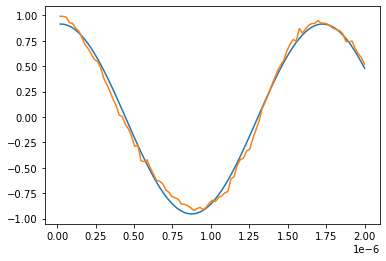

In [25]:
# plt.plot(t, (rabi_func(t, *res.x)-p)**2)
plt.plot(t, rabi_func(t, *res.x))
plt.plot(t, p)

Verify the model